# Quantification

Ce notebook explore la quantification des modèles en comparant leur **justesse (accuracy)** et leurs **temps de calcul** lorsqu'ils sont quantifiés en **Float16** et **Int8**.

L'entraînement est réalisé sur le jeu de données Fashion MNIST. L'architecture du modèle inclut **plusieurs couches denses**, bien que leur nombre soit excessif pour cette tâche. Ces couches supplémentaires ont été ajoutées intentionnellement afin d'augmenter le temps d'inférence, ce qui facilite la comparaison des performances des modèles quantifiés.

## Comparaison CPU/GPU

Par défaut, l'exécution se fait sur CPU. Pour comparer les performances sur GPU, vous devez :

1. Exécuter entièrement ce notebook en mode CPU.

2. Changer le type d'exécution en sélectionnant le GPU. Pour ce faire, cliquez sur "Modifier le type d'exécution" dans les paramètres du notebook.

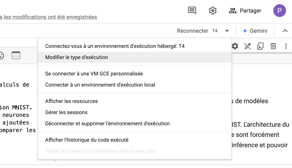

3. Puis choisir "T4 GPU" :

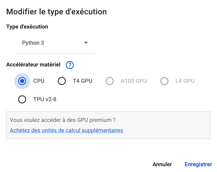


## Importation des bibliothèques

In [ ]:
import tensorflow as tf
import numpy as np
import time

## Création des fonctions

In [ ]:
# Fonction pour convertir et sauvegarder des modèles quantifiés
def convert_and_save_quantized_model(model, optimization, filename, representative_data=None, target_type=None):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [optimization]

    if representative_data:
        converter.representative_dataset = representative_data
    if target_type:
        converter.target_spec.supported_types = target_type

    tflite_model = converter.convert()
    with open(filename, 'wb') as f:
        f.write(tflite_model)

# Représentative dataset pour la quantification int8
def representative_data_gen():
    for input_value in X_test[:100]:
        yield [np.expand_dims(input_value, axis=0).astype(np.float32)]

# Fonction pour obtenir la prediction et mesurer le temps d'inférence
def measure_inference_time(interpreter, input_data):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], input_data)
    start_time = time.time()
    interpreter.invoke()
    inference_time = time.time() - start_time
    output = interpreter.get_tensor(output_details[0]['index'])
    return output, inference_time

# Fonction pour évaluer les performances
def evaluate_model(interpreter, X_test, y_test):
    input_details = interpreter.get_input_details()
    correct_predictions = 0
    total_time = 0.0

    for i, (x, y) in enumerate(zip(X_test, y_test)):
        input_data = np.expand_dims(x, axis=0).astype(input_details[0]['dtype'])

        output, inference_time = measure_inference_time(interpreter, input_data)
        total_time += inference_time

        if np.argmax(output) == y:
            correct_predictions += 1

    accuracy = correct_predictions / len(X_test)
    avg_time = total_time / len(X_test)
    return accuracy, avg_time

## Récupération des données Fashion MNIST

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

## Construction et entrainement du modèle

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=1, validation_split=0.1)

## Quantification des modèles en Float16 et int8

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Conversion des modèles quantifiés
convert_and_save_quantized_model(model, tf.lite.Optimize.DEFAULT, 'model_fp16.tflite', target_type=[tf.float16])
convert_and_save_quantized_model(model, tf.lite.Optimize.DEFAULT, 'model_int8.tflite', representative_data_gen)

## Evaluation des modèles

In [ ]:
interpreters = {
    "Modèle d'origine Float32": tf.lite.Interpreter(model_path="model.tflite"),
    "Modèle quantifié après entrainement en Float16": tf.lite.Interpreter(model_path="model_fp16.tflite"),
    "Modèle quantifié après entrainement en Int8": tf.lite.Interpreter(model_path="model_int8.tflite")
}

for interpreter in interpreters.values():
    interpreter.allocate_tensors()

# Comparaison des performances
results = {}
for model_name, interpreter in interpreters.items():
    accuracy, avg_time = evaluate_model(interpreter, X_test, y_test)
    results[model_name] = {
        "Justesse": accuracy,
        "Temps_inference": avg_time
    }

# Afficher les résultats
for model_name, metrics in results.items():
    print(f"{model_name} :")
    print(f" - Justesse (accuracy) : {metrics['Justesse']:.4f}")
    print(f" - Temps d'inférence moyen : {metrics['Temps_inference']:.6f} secondes\n")